In [2]:
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU,Dense
import numpy as np
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt

In [3]:
batch_size = 64
epochs = 10
latent_dim = 256
num_samples = 20000

In [4]:
data_path = 'vie.txt'

In [5]:
input_texts = []
output_texts = []
input_characters = set()
output_characters = set()

with open(data_path, 'r', encoding = 'utf-8') as f:
    lines = f.read().split('\n')
for line in lines[:min(num_samples,len(lines)-1)]:
    input_text, output_text, _ = line.split('\t')
    
    # We use 'tab' as the 'start sequence' character
    # for the targets, and '\n' as the 'end sequence' character.
    
    output_text = '\t' + output_text + '\n'
    input_texts.append(input_text)
    output_texts.append(output_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in output_text:
        if char not in output_characters:
            output_characters.add(char)


In [6]:
len(output_characters)

164

In [7]:
input_characters = sorted(list(input_characters))
output_characters = sorted(list(output_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(output_characters)
max_encoder_seq_length = max([len(text) for text in input_texts])
max_decoder_seq_length = max([len(text) for text in output_texts])

In [8]:
print("Number of Samples:", len(input_texts))
print('Number of unique input Tokens:' , num_encoder_tokens)
print('Number of unique output Tokens:' , num_decoder_tokens)
print('Max sequence length for inputs:' , max_encoder_seq_length)
print('Max sequence length for outputs:' , max_decoder_seq_length)

Number of Samples: 9428
Number of unique input Tokens: 74
Number of unique output Tokens: 164
Max sequence length for inputs: 182
Max sequence length for outputs: 163


In [9]:
input_token_index = dict(
    [(char,i) for i,char in enumerate(input_characters)])

output_token_index = dict(
    [(char,i) for i,char in enumerate(output_characters)])

In [10]:
input_token_index , output_token_index

({' ': 0,
  '!': 1,
  '"': 2,
  '$': 3,
  '%': 4,
  "'": 5,
  '+': 6,
  ',': 7,
  '-': 8,
  '.': 9,
  '0': 10,
  '1': 11,
  '2': 12,
  '3': 13,
  '4': 14,
  '5': 15,
  '6': 16,
  '7': 17,
  '8': 18,
  '9': 19,
  ':': 20,
  '?': 21,
  'A': 22,
  'B': 23,
  'C': 24,
  'D': 25,
  'E': 26,
  'F': 27,
  'G': 28,
  'H': 29,
  'I': 30,
  'J': 31,
  'K': 32,
  'L': 33,
  'M': 34,
  'N': 35,
  'O': 36,
  'P': 37,
  'Q': 38,
  'R': 39,
  'S': 40,
  'T': 41,
  'U': 42,
  'V': 43,
  'W': 44,
  'Y': 45,
  'a': 46,
  'b': 47,
  'c': 48,
  'd': 49,
  'e': 50,
  'f': 51,
  'g': 52,
  'h': 53,
  'i': 54,
  'j': 55,
  'k': 56,
  'l': 57,
  'm': 58,
  'n': 59,
  'o': 60,
  'p': 61,
  'q': 62,
  'r': 63,
  's': 64,
  't': 65,
  'u': 66,
  'v': 67,
  'w': 68,
  'x': 69,
  'y': 70,
  'z': 71,
  '’': 72,
  '€': 73},
 {'\t': 0,
  '\n': 1,
  ' ': 2,
  '!': 3,
  '"': 4,
  '$': 5,
  '%': 6,
  '(': 7,
  ')': 8,
  '+': 9,
  ',': 10,
  '-': 11,
  '.': 12,
  '/': 13,
  '0': 14,
  '1': 15,
  '2': 16,
  '3': 17,
  '4'

In [11]:
encoder_input_data = np.zeros(
    (len(input_texts),max_encoder_seq_length,num_encoder_tokens),dtype = 'float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length , num_decoder_tokens), dtype = 'float32')
decoder_output_data = np.zeros(
    (len(input_texts), max_decoder_seq_length,num_decoder_tokens) , dtype = 'float32')

In [12]:
for i,(input_text,output_text) in enumerate(zip(input_texts,output_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i,t,input_token_index[char]] = 1.
    encoder_input_data[i,t+1:,input_token_index[' ']] = 1.
    
    for t, char in enumerate(output_text):
        # decoder_output_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i,t,output_token_index[char]] = 1.
        if t>0:
            # decoder_output_data will be ahead by one timestep
            # and will not include the start character
            decoder_output_data[i,t-1,output_token_index[char]] = 1.
    decoder_input_data[i,t+1:, output_token_index[' ']] = 1.
    decoder_output_data[i , t: , output_token_index[' ']] = 1.

In [13]:
encoder_input_data[0].shape

(182, 74)

In [14]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = GRU(latent_dim, return_state=True)
encoder_outputs, state = encoder(encoder_inputs)
encoder_states = [state]

In [15]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_gru = GRU(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, state = decoder_gru(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [16]:
def f1_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    
    f1_val = 2 * (precision * recall) / (precision + recall + K.epsilon())
    return f1_val

In [17]:
# Define the model that will turn
# 'encoder_input_data' & 'decoder_input_data' into 'decoder_output_data'
model = Model([encoder_inputs,decoder_inputs], decoder_outputs)

#Run training:
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy' , metrics = ['accuracy',f1_score])
model = model.fit([encoder_input_data,decoder_input_data], decoder_output_data,
         batch_size=batch_size,
         epochs = epochs,
         validation_split=0.2)
train_acc = model.history['accuracy']
val_acc = model.history['val_accuracy']
train_f1 = model.history['f1_score']
val_f1 = model.history['val_f1_score']

Epoch 1/10
118/118 [==============================] - 113s 897ms/step - loss: 0.9849 - accuracy: 0.8380 - f1_score: 0.8406 - val_loss: 1.3205 - val_accuracy: 0.7429 - val_f1_score: 0.7561
Epoch 2/10
118/118 [==============================] - 105s 886ms/step - loss: 0.7055 - accuracy: 0.8469 - f1_score: 0.8797 - val_loss: 1.1168 - val_accuracy: 0.7429 - val_f1_score: 0.7916
Epoch 3/10
118/118 [==============================] - 118s 996ms/step - loss: 0.5902 - accuracy: 0.8597 - f1_score: 0.8932 - val_loss: 0.9301 - val_accuracy: 0.7789 - val_f1_score: 0.8046
Epoch 4/10
118/118 [==============================] - 117s 990ms/step - loss: 0.4914 - accuracy: 0.8769 - f1_score: 0.9049 - val_loss: 0.8275 - val_accuracy: 0.7915 - val_f1_score: 0.8261
Epoch 5/10
118/118 [==============================] - 115s 976ms/step - loss: 0.4443 - accuracy: 0.8837 - f1_score: 0.9121 - val_loss: 0.7686 - val_accuracy: 0.8038 - val_f1_score: 0.8375
Epoch 6/10
118/118 [==============================] - 113s 9

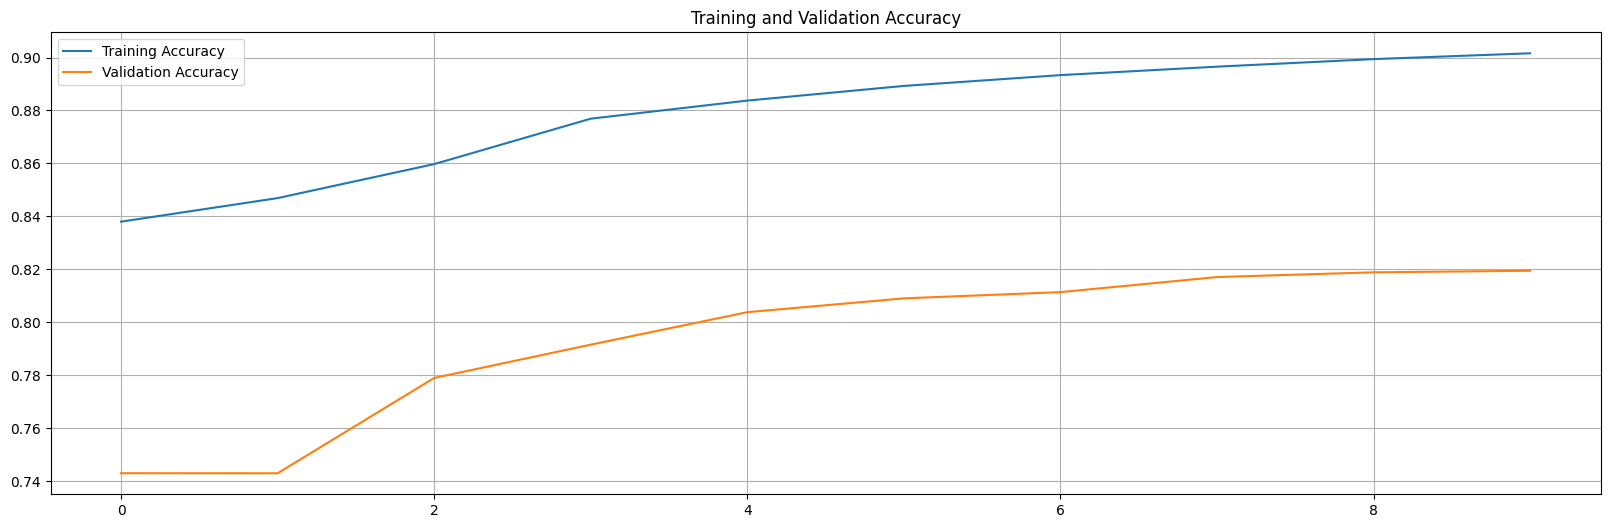

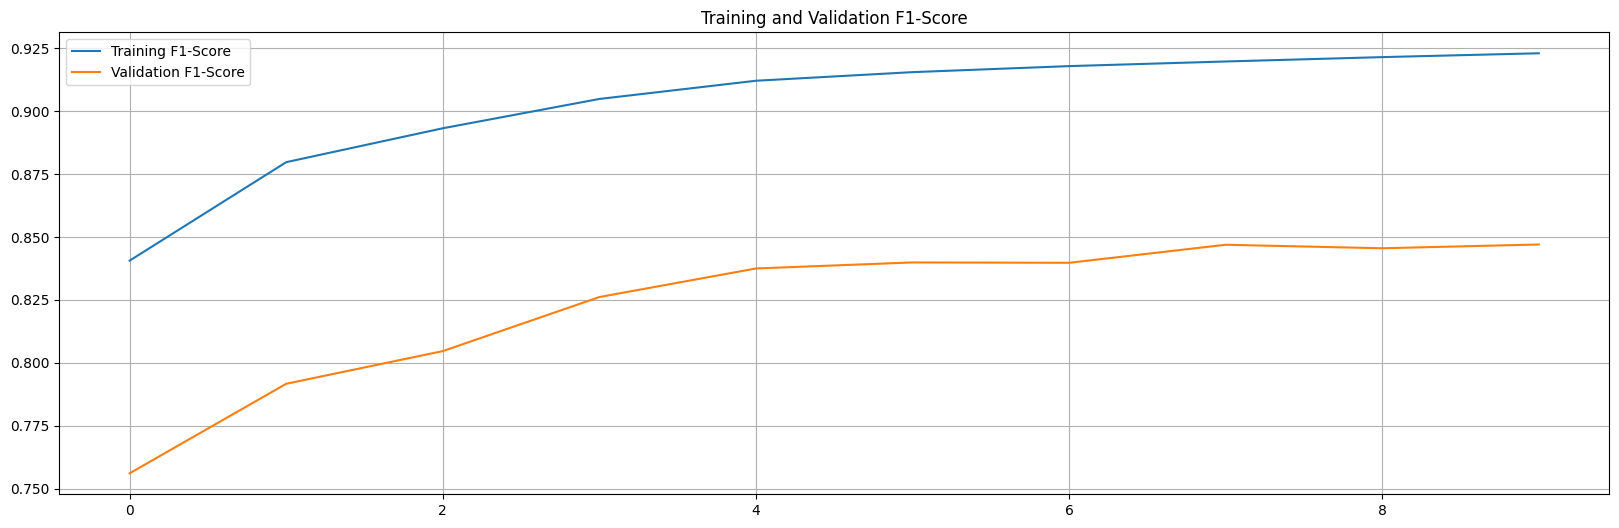

In [18]:
epochs_range = range(epochs)
plt.figure(figsize=(20, 6))

plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 6))
plt.plot(epochs_range, train_f1, label='Training F1-Score')
plt.plot(epochs_range, val_f1, label='Validation F1-Score')
plt.title('Training and Validation F1-Score')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
# define sampling models:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape = (latent_dim,))
decoder_state_input_c = Input(shape = (latent_dim,))
decoder_input_states = [decoder_state_input_h,decoder_state_input_c]

decoder_outputs,state_h,state_c = decoder_gru(decoder_inputs, initial_state=decoder_input_states)
decoder_states = [state_h,state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs]+decoder_input_states,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i,char) for char,i in input_token_index.items())
reverse_output_char_index = dict(
    (i,char) for char,i in output_token_index.items())

def decode_sequence(input_seq):
    states_value= encoder_model.predict(input_seq)
    output_seq = np.zeros((1,1,num_decoder_tokens))
    output_seq[0,0,output_token_index['\t']] = 1
    
    stop_condition = False
    decoded_sentences = ''
    while not stop_condition:
        output_tokens,h,c = decoder_model.predict(
            [output_seq]+ states_value)
        
        sampled_token_index = np.argmax(output_tokens[0,-1, :])
        sampled_char = reverse_output_char_index[sampled_token_index]
        decoded_sentences += sampled_char

        if(sampled_char == '\n' or len(decoded_sentences) > max_decoder_seq_length):
            stop_condition = True
        
        #update the target sequence (of length 1):
        output_seq = np.zeros((1,1,num_decoder_tokens))
        output_seq[0,0,sampled_token_index] = 1
        
        states_value = [h,c]
    return decoded_sentences

for seq_index in range(20):
    # take one sequence for trying out decoding:
    input_seq = encoder_input_data[seq_index:seq_index+1]
    decoded_sentences = decode_sequence(input_seq)
    print('ProjectGurukul Project: English to French Translation ')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:' , decoded_sentences)

ValueError: Exception encountered when calling layer "gru_1" (type GRU).

Layer has 1 states but was passed 2 initial states. Received: initial_state=[<tf.Tensor 'Placeholder_1:0' shape=(None, 256) dtype=float32>, <tf.Tensor 'Placeholder_2:0' shape=(None, 256) dtype=float32>]

Call arguments received by layer "gru_1" (type GRU):
  • inputs=['tf.Tensor(shape=(None, None, 164), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)', 'tf.Tensor(shape=(None, 256), dtype=float32)']
  • mask=None
  • training=None
  • initial_state=None

In [ ]:
# def preprocess_and_tokenize(sentence):
#     sentence = sentence.replace('\t', '').replace('\n', '')
#     tokens = word_tokenize(sentence.lower())
#     return tokens

In [ ]:
# meteor_references = []
# meteor_hypotheses = []

# for seq_index in range(20):
#     input_seq = encoder_input_data[seq_index:seq_index + 1]
#     decoded_sentence = decode_sequence(input_seq)

#     input_tokens = preprocess_and_tokenize(input_texts[seq_index])
#     decoded_tokens = preprocess_and_tokenize(decoded_sentence)

#     print('Input sentence:', ' '.join(input_tokens))
#     print('Decoded sentence:', ' '.join(decoded_tokens))

#     meteor_references.append(input_tokens)
#     meteor_hypotheses.append(decoded_tokens)

#     print('-' * 20)

# meteor = meteor_score.corpus_meteor_score(meteor_references, meteor_hypotheses)
# print('Overall METEOR Score:', meteor)

1/1 [==============================] - 0s 20ms/step


LookupError: 
**********************************************************************
  Resource [93mpunkt[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt/english.pickle[0m

  Searched in:
    - 'C:\\Users\\Nhat Thanh/nltk_data'
    - 'c:\\Users\\Nhat Thanh\\AppData\\Local\\Programs\\Python\\Python311\\nltk_data'
    - 'c:\\Users\\Nhat Thanh\\AppData\\Local\\Programs\\Python\\Python311\\share\\nltk_data'
    - 'c:\\Users\\Nhat Thanh\\AppData\\Local\\Programs\\Python\\Python311\\lib\\nltk_data'
    - 'C:\\Users\\Nhat Thanh\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
    - ''
**********************************************************************
